In [ ]:
!pip install scikeras
!pip install -U keras-tuner

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout



import yfinance as yf

from datetime import datetime, timedelta

import requests
import json

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import datetime



end_date = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.datetime.today() - datetime.timedelta(days=365*20)).strftime('%Y-%m-%d')

tesla_data = yf.download('TSLA', start=start_date, end=end_date)
apple_data = yf.download('AAPL', start=start_date, end=end_date)
amazon_data = yf.download('AMZN', start=start_date, end=end_date)


#GOLD Data

gold_data = yf.download('GC=F', start=start_date, end=end_date)


#ETF's

api_key = '2YW9PTCOWXKLLTNS'


qqq_symbol = 'QQQ'
spdr_symbol = 'SPY'
ishr_symbol = 'IWM'

output_format = 'json'

base_url = 'https://www.alphavantage.co/query'

def fetch_etf_data(api_key, symbol, output_format, start_date, end_date):
    # Define the API parameters
    params = {
        'function': 'TIME_SERIES_DAILY',  # Daily time series data
        'symbol': symbol,
        'outputsize': 'full',  # Retrieve full historical data
        'datatype': output_format,
        'apikey': api_key,
        'start_date': start_date,  # Specify the start date
        'end_date': end_date      # Specify the end date
    }

    try:

        response = requests.get(base_url, params=params)
        data = response.json() if output_format == 'json' else response.text

        # Check for API request success
        if 'Time Series (Daily)' in data:
            return data['Time Series (Daily)']
        else:
            print("API request was not successful. Check your API key or symbol.")
            return None

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


invesco_data = pd.DataFrame(fetch_etf_data(api_key, qqq_symbol, output_format, start_date, end_date))
ishares_data = pd.DataFrame(fetch_etf_data(api_key, ishr_symbol, output_format, start_date, end_date))
spdr_data = pd.DataFrame(fetch_etf_data(api_key, spdr_symbol, output_format, start_date, end_date))

spdr_data = spdr_data.T
ishares_data = ishares_data.T
invesco_data = invesco_data.T


#bitcoin

api_key = "5DyC56vN-RWdz61xD4-m"
url = f"https://www.quandl.com/api/v3/datasets/BCHAIN/MKPRU/data.json?start_date={start_date}&end_date={end_date}&api_key={api_key}"
response = requests.get(url)
bitcon_data = response.json()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


**LSTM PRICE PREDICTION**

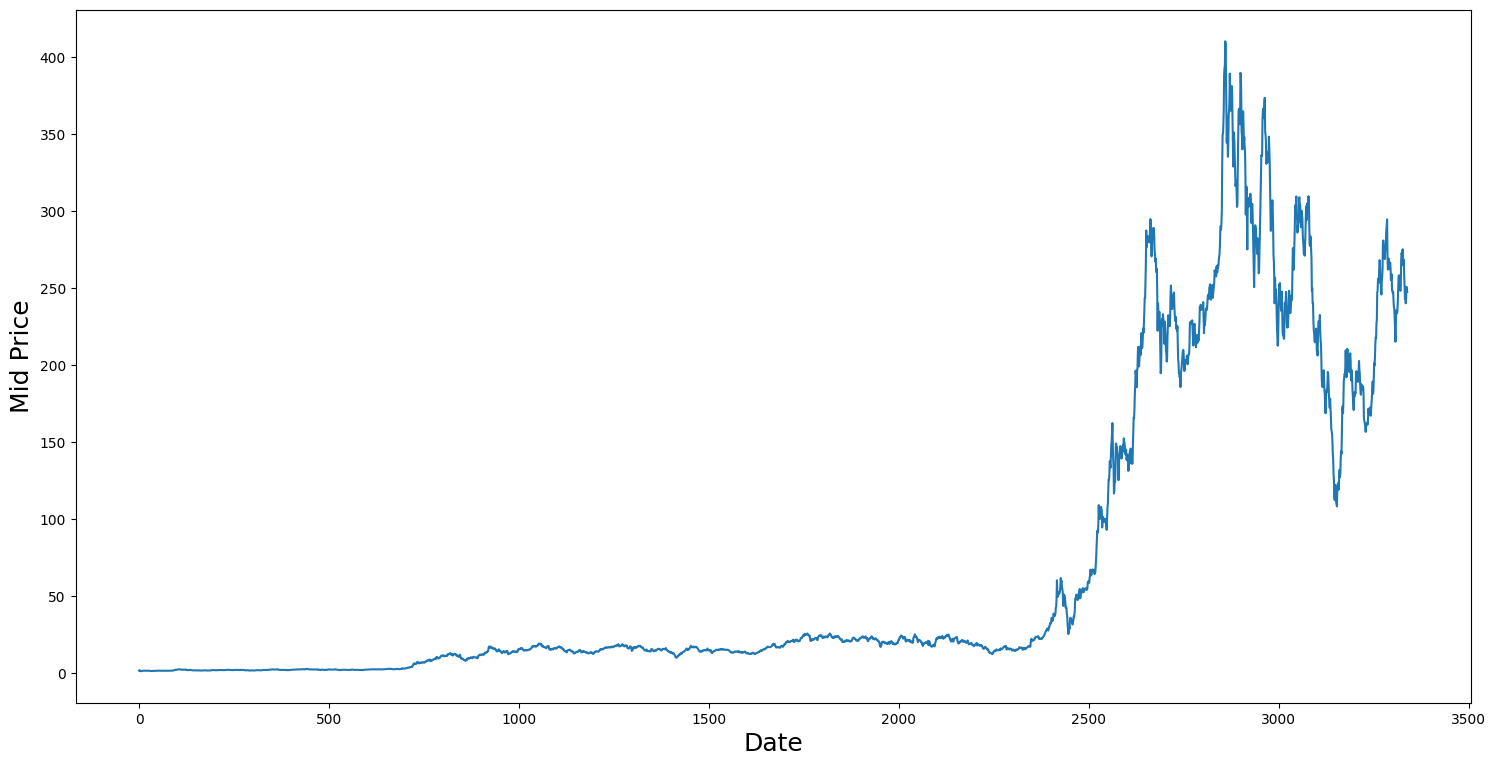

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(tesla_data.shape[0]),(tesla_data['Low']+tesla_data['High'])/2.0)

plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam


# Extract the 'Close' prices as the target variable
prices = tesla_data['Close'].values.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Define a function to create sequences for LSTM training
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Hyperparameters
sequence_length = 60  # Adjust as needed
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

# Calculate split indices
total_len = len(prices_scaled)
train_split = int(total_len * train_ratio)
validation_split = int(total_len * (train_ratio + validation_ratio))

# Create sequences for training
X, y = create_sequences(prices_scaled, sequence_length)

# Split data into training, validation, and testing sets
X_train, X_val, X_test = X[:train_split], X[train_split:validation_split], X[validation_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:validation_split], y[validation_split:]

# Build and train the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer=Adam(),
              metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_data=(X_val, y_val))




# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual prices
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Epoch 1/50
74/74 - 13s - loss: 1.6926e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0108 - val_mean_absolute_error: 0.0833 - 13s/epoch - 180ms/step
Epoch 2/50
74/74 - 7s - loss: 6.0674e-06 - mean_absolute_error: 0.0018 - val_loss: 0.0098 - val_mean_absolute_error: 0.0792 - 7s/epoch - 99ms/step
Epoch 3/50
74/74 - 6s - loss: 5.7818e-06 - mean_absolute_error: 0.0018 - val_loss: 0.0116 - val_mean_absolute_error: 0.0865 - 6s/epoch - 78ms/step
Epoch 4/50
74/74 - 7s - loss: 4.9804e-06 - mean_absolute_error: 0.0016 - val_loss: 0.0108 - val_mean_absolute_error: 0.0828 - 7s/epoch - 97ms/step
Epoch 5/50
74/74 - 6s - loss: 4.8416e-06 - mean_absolute_error: 0.0016 - val_loss: 0.0103 - val_mean_absolute_error: 0.0807 - 6s/epoch - 77ms/step
Epoch 6/50
74/74 - 8s - loss: 5.7417e-06 - mean_absolute_error: 0.0018 - val_loss: 0.0122 - val_mean_absolute_error: 0.0886 - 8s/epoch - 114ms/step
Epoch 7/50
74/74 - 6s - loss: 4.7352e-06 - mean_absolute_error: 0.0016 - val_loss: 0.0120 - val_mean_absolute_erro

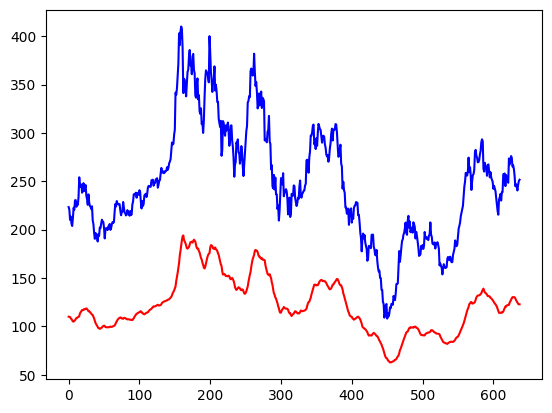

In [ ]:
plt.plot(y_pred_actual,color='red', label='prediction')
plt.plot(y_test_actual,color='blue', label='y_test')

In [ ]:

def build_model():
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(60,1), return_sequences=True))
        model.add(LSTM(32, input_shape=(60,1), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
        #model.add(Dropout(d))
        model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
        model.compile(loss='mse',optimizer='adam',metrics=['mae'])
        return model

model = build_model()

history = model.fit(X_train,
                  y_train,
                  batch_size=128,
                  epochs=35,
                  validation_split=0.2,
                  verbose=2)


In [ ]:
import math
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual prices
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

trainScore = model.evaluate(X_train, y_train, verbose=0)
testScore = model.evaluate(X_test, y_test, verbose=0)


print('Trainscore RMSE \tTrain Mean abs Error \tTestscore Rmse \t Test Mean abs Error')
print('%.9f \t\t %.9f \t\t %.9f \t\t %.9f' % (math.sqrt(trainScore[0]),trainScore[1],math.sqrt(testScore[0]),testScore[1]))


In [ ]:
from kerastuner.tuners import RandomSearch
import yfinance as yf
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from kerastuner.tuners import RandomSearch


# Extract the 'Close' prices as the target variable
prices = tesla_data['Close'].values.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Define a function to create sequences for LSTM training
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Hyperparameters
sequence_length = 60  # Adjust as needed
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

# Calculate split indices
total_len = len(prices_scaled)
train_split = int(total_len * train_ratio)
validation_split = int(total_len * (train_ratio + validation_ratio))

# Create sequences for training
X, y = create_sequences(prices_scaled, sequence_length)

# Split data into training, validation, and testing sets
X_train, X_val, X_test = X[:train_split], X[train_split:validation_split], X[validation_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:validation_split], y[validation_split:]

# Build and train the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense

def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= (60,1)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid', 'tanh'],default='relu')))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid', 'tanh'],default='relu')))

    model.compile(loss='mse', optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),metrics = ['mae'])

    return model

tuner = RandomSearch(model_builder, max_trials = 5, objective= 'val_loss', executions_per_trial =3,directory = "./")

tuner.search(x=X_train, y=y_train, epochs = 50, batch_size =256, validation_data=(X_test, y_test))



best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 4 Complete [00h 01m 18s]
val_loss: 0.037607270603378616

Best val_loss So Far: 0.037607270603378616
Total elapsed time: 00h 09m 01s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
352               |32                |input_unit
3                 |1                 |n_layers
256               |128               |lstm_0_units
256               |288               |layer_2_neurons
tanh              |tanh              |dense_activation
0.001             |0.01              |learning_rate
256               |160               |lstm_1_units
288               |224               |lstm_2_units
32                |160               |lstm_3_units

Epoch 1/50
10/10 [==============================] - 12s 314ms/step - loss: 8.5632e-04 - mae: 0.0237 - val_loss: 0.3038 - val_mae: 0.5328
Epoch 2/50
10/10 [==============================] - 1s 121ms/step - loss: 2.3683e-04 - mae: 0.0125 - val_loss: 0.0112 - val_mae: 0.0827
Epoch 3/50
10/10 [=============================

In [ ]:
model = model_builder(best_hps)

estp = EarlyStopping(patience=8, verbose=2)

history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val), callbacks=estp)



Epoch 1/100
73/73 [==============================] - 17s 48ms/step - loss: 1.5791e-04 - mae: 0.0078 - val_loss: 0.0089 - val_mae: 0.0722
Epoch 2/100
73/73 [==============================] - 2s 24ms/step - loss: 2.2610e-05 - mae: 0.0038 - val_loss: 0.0043 - val_mae: 0.0458
Epoch 3/100
73/73 [==============================] - 2s 23ms/step - loss: 1.6655e-05 - mae: 0.0032 - val_loss: 0.0066 - val_mae: 0.0596
Epoch 4/100
73/73 [==============================] - 2s 24ms/step - loss: 1.4102e-05 - mae: 0.0029 - val_loss: 0.0101 - val_mae: 0.0777
Epoch 5/100
73/73 [==============================] - 2s 25ms/step - loss: 1.1944e-05 - mae: 0.0027 - val_loss: 0.0089 - val_mae: 0.0714
Epoch 6/100
73/73 [==============================] - 2s 24ms/step - loss: 1.6856e-05 - mae: 0.0033 - val_loss: 0.0068 - val_mae: 0.0606
Epoch 7/100
73/73 [==============================] - 2s 23ms/step - loss: 1.0764e-05 - mae: 0.0025 - val_loss: 0.0062 - val_mae: 0.0568
Epoch 8/100
73/73 [============================

ValueError: ignored

In [ ]:
X_test  = X_test.reshape(474, 60)
x = pd.DataFrame(X_test)
x
y_pred = model.predict(x)


y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

In [ ]:
best_hps